In [1]:
from sklearn.model_selection import train_test_split
from config import *
from utils import *
from load_data import load_data, load_senti_data

In [2]:
X_train, y_train, X_val, y_val = load_data()

In [3]:
X_train_with_target = X_train.copy()
X_train_with_target['AdoptionSpeed'] = y_train
target_encoding_features = ['Breed1', 'Breed2','Color1', 'Color2', 'Color3','State']
for feature in target_encoding_features:
    target_mean = X_train_with_target.groupby(feature)['AdoptionSpeed'].mean()
    X_train[(feature+'_encoded')] = X_train[feature].map(target_mean)

In [4]:
X_train = X_train.drop(target_encoding_features, axis=1)

In [5]:
X_train.columns

Index(['Type', 'Age', 'Gender', 'MaturitySize', 'FurLength', 'Vaccinated',
       'Dewormed', 'Sterilized', 'Health', 'Fee', 'VideoAmt', 'PhotoAmt',
       'Breed1_encoded', 'Breed2_encoded', 'Color1_encoded', 'Color2_encoded',
       'Color3_encoded', 'State_encoded'],
      dtype='object')

In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
ordinal_features = ['MaturitySize', 'FurLength', 'Health', 'Vaccinated', 'Dewormed', 'Sterilized']
one_hot_features = ['Type','Gender']
target_encoded_features = ['Breed1_encoded', 'Breed2_encoded', 'Color1_encoded',
       'Color2_encoded', 'Color3_encoded', 'State_encoded']
preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore',sparse_output=False), one_hot_features),
            ('ord', OrdinalEncoder(), ordinal_features),
            ('target', 'passthrough', target_encoded_features)

        ]
    )
X_train_processed = preprocessor.fit_transform(X_train)
# X_val_processed = preprocessor.transform(X_val)

In [7]:
from pygam import LogisticGAM, s, f
from sklearn.metrics import accuracy_score

In [8]:
preprocessor.get_feature_names_out()

array(['num__Age', 'num__Fee', 'num__VideoAmt', 'num__PhotoAmt',
       'cat__Type_1.0', 'cat__Type_2.0', 'cat__Gender_1.0',
       'cat__Gender_2.0', 'ord__MaturitySize', 'ord__FurLength',
       'ord__Health', 'ord__Vaccinated', 'ord__Dewormed',
       'ord__Sterilized', 'target__Breed1_encoded',
       'target__Breed2_encoded', 'target__Color1_encoded',
       'target__Color2_encoded', 'target__Color3_encoded',
       'target__State_encoded'], dtype=object)

In [9]:
len(preprocessor.get_feature_names_out())

20

In [10]:
y_train_binary = y_train.map(lambda x: 0 if x in [0, 1, 2] else 1)

In [11]:
gam = LogisticGAM(
    s(0) + s(1) + s(2) + s(3) +
    f(4) + f(5) + 
    f(6) + f(7) +
    s(8) + s(9) + s(10) + s(11) + s(12) + s(13) +
    s(14) + s(15) + s(16) + s(17) + s(18) + s(19)
)


gam.fit(X_train_processed, y_train_binary)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + f(4) + f(5) + f(6) + f(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + intercept,
   tol=0.0001, verbose=False)

In [12]:
lam_grid = [0.2,0.21, 0.22, 0.23, 0.24, 0.25]
gam.gridsearch(X_train_processed, y_train_binary, lam=lam_grid)

100% (6 of 6) |##########################| Elapsed Time: 0:00:07 Time:  0:00:070:01


LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + f(4) + f(5) + f(6) + f(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + intercept,
   tol=0.0001, verbose=False)

In [13]:
X_val_with_target = X_val.copy()
X_val_with_target['AdoptionSpeed'] = y_val
target_encoding_features = ['Breed1', 'Breed2','Color1', 'Color2', 'Color3','State']
for feature in target_encoding_features:
    target_mean_val = X_val_with_target.groupby(feature)['AdoptionSpeed'].mean()
    X_val[(feature+'_encoded')] = X_val[feature].map(target_mean_val)

In [14]:
X_val = X_val.drop(target_encoding_features, axis=1)
X_val.columns

Index(['Type', 'Age', 'Gender', 'MaturitySize', 'FurLength', 'Vaccinated',
       'Dewormed', 'Sterilized', 'Health', 'Fee', 'VideoAmt', 'PhotoAmt',
       'Breed1_encoded', 'Breed2_encoded', 'Color1_encoded', 'Color2_encoded',
       'Color3_encoded', 'State_encoded'],
      dtype='object')

In [15]:
X_val_processed = preprocessor.transform(X_val)

In [16]:
y_val_binary = y_val.map(lambda x: 0 if x in [0, 1, 2] else 1)

In [17]:
y_val_pred = gam.predict(X_val_processed)

In [18]:
y_val_pred.astype(int)

array([1, 0, 1, ..., 0, 0, 0])

In [19]:
y_val_binary_array = y_val_binary['AdoptionSpeed'].to_numpy()
y_val_binary_array

array([1, 0, 0, ..., 1, 0, 1], dtype=int64)

In [20]:
accuracy = (y_val_pred.astype(int) == y_val_binary_array).mean()
accuracy

0.6639080459770115

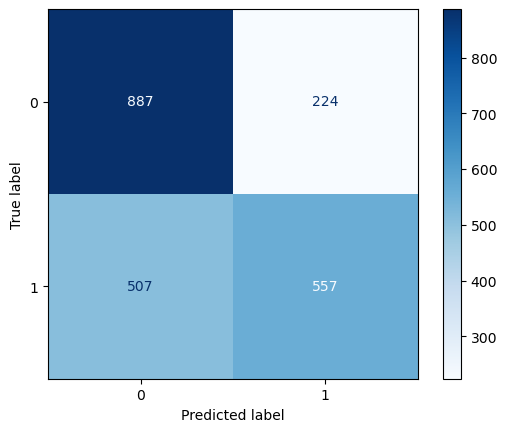

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_val_binary_array, y_val_pred.astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')

In [22]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     91.3296
Link Function:                        LogitLink Log Likelihood:                                 -5288.2337
Number of Samples:                         8698 AIC:                                            10759.1264
                                                AICc:                                           10761.1293
                                                UBRE:                                               3.2454
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1224
Feature Function                  Lam

C:\Users\syqro\AppData\Local\Temp\ipykernel_23780\869333826.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [23]:
from sklearn.metrics import accuracy_score
import numpy as np

feature_groups = {
    "type": ["cat__Type_1.0", "cat__Type_2.0"],
    "gender": ["cat__Gender_1.0", "cat__Gender_2.0"],
    "breed": ["target__Breed1_encoded", "target__Breed2_encoded"],
    "color": ["target__Color1_encoded", "target__Color2_encoded", "target__Color3_encoded"],
}

all_features = preprocessor.get_feature_names_out()
excluded_features = sum(feature_groups.values(), [])
individual_features = [f for f in all_features if f not in excluded_features]
features_to_test = {f"feature_{col}": [col] for col in individual_features}
features_to_test.update(feature_groups)

baseline_accuracy = accuracy_score(y_val_binary, gam.predict(X_val_processed))

drop_in_accuracies = []

for feature_or_group, columns_to_drop in features_to_test.items():
    indices_to_drop = [i for i, col in enumerate(all_features) if col in columns_to_drop]
    X_train_reduced = np.delete(X_train_processed, indices_to_drop, axis=1)
    X_val_reduced = np.delete(X_val_processed, indices_to_drop, axis=1)

    gam_reduced = LogisticGAM().fit(X_train_reduced, y_train_binary)

    y_val_pred = gam_reduced.predict(X_val_reduced)
    reduced_accuracy = accuracy_score(y_val_binary, y_val_pred)
    drop_in_accuracy = baseline_accuracy - reduced_accuracy
    
    drop_in_accuracies.append((feature_or_group, drop_in_accuracy))

print("Drop-in-Accuracy Results:")
for feature_or_group, drop in drop_in_accuracies:
    print(f"{feature_or_group}: {drop:.4f}")


Drop-in-Accuracy Results:
feature_num__Age: 0.0041
feature_num__Fee: -0.0032
feature_num__VideoAmt: -0.0055
feature_num__PhotoAmt: 0.0046
feature_ord__MaturitySize: -0.0083
feature_ord__FurLength: -0.0074
feature_ord__Health: -0.0051
feature_ord__Vaccinated: -0.0051
feature_ord__Dewormed: -0.0083
feature_ord__Sterilized: -0.0060
feature_target__State_encoded: -0.0055
type: -0.0046
gender: -0.0041
breed: 0.0414
color: -0.0055


这里在测试logistics衡量每个feature的有效程度，可以看图

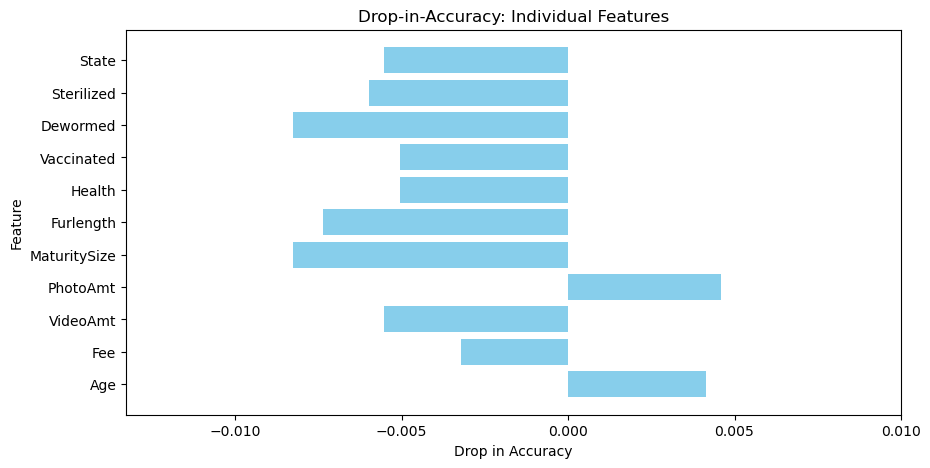

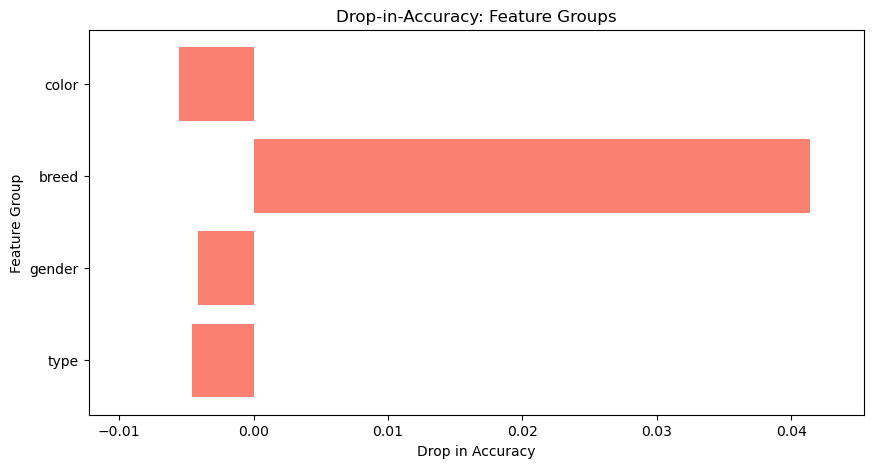

In [24]:
import matplotlib.pyplot as plt
individual_results = [(f, d) for f, d in drop_in_accuracies if f.startswith("feature_")]
group_results = [(g, d) for g, d in drop_in_accuracies if g in feature_groups]

all_drops = [d for _, d in drop_in_accuracies]
x_min, x_max = min(all_drops), max(all_drops)

if individual_results:
    features, drops = zip(*individual_results)
    # print(features)
    features = ['Age', 'Fee', 'VideoAmt', 'PhotoAmt', 'MaturitySize', 'Furlength', 'Health', 'Vaccinated', 'Dewormed', 'Sterilized', 'State']
    plt.figure(figsize=(10, 5))
    plt.barh(features, drops, color='skyblue')
    plt.xlim(x_min-0.005, 0.01)  # Set consistent x-axis range
    plt.xlabel("Drop in Accuracy")
    plt.ylabel("Feature")
    plt.title("Drop-in-Accuracy: Individual Features")
    plt.show()

# Plot feature groups
if group_results:
    groups, drops = zip(*group_results)
    plt.figure(figsize=(10, 5))
    plt.barh(groups, drops, color='salmon')
    plt.xlim(x_min-0.004, x_max+0.004)  # Set consistent x-axis range
    plt.xlabel("Drop in Accuracy")
    plt.ylabel("Feature Group")
    plt.title("Drop-in-Accuracy: Feature Groups")
    plt.show()

In [25]:
from sklearn.metrics import accuracy_score
import numpy as np

# Define features to remove
features_to_remove = ["num__Age", "target__Breed1_encoded", "target__Breed2_encoded"]

# Get all feature names from the preprocessor
all_features = preprocessor.get_feature_names_out()

# Identify indices of features to remove
indices_to_remove = [i for i, col in enumerate(all_features) if col in features_to_remove]

# Remove the selected columns from the processed data
X_train_reduced = np.delete(X_train_processed, indices_to_remove, axis=1)
X_val_reduced = np.delete(X_val_processed, indices_to_remove, axis=1)

# Train a new GAM without the removed features
gam_reduced = LogisticGAM().fit(X_train_reduced, y_train_binary)

# Evaluate the reduced model
y_val_pred = gam_reduced.predict(X_val_reduced)
reduced_accuracy = accuracy_score(y_val_binary, y_val_pred)

# Compare with the original GAM's accuracy
baseline_accuracy = accuracy_score(y_val_binary, gam.predict(X_val_processed))
accuracy_drop = baseline_accuracy - reduced_accuracy

# Print results
print(f"Baseline Accuracy (with all features): {baseline_accuracy:.4f}")
print(f"Reduced Accuracy (without Age and Breed): {reduced_accuracy:.4f}")
print(f"Drop in Accuracy: {accuracy_drop:.4f}")


Baseline Accuracy (with all features): 0.6639
Reduced Accuracy (without Age and Breed): 0.6124
Drop in Accuracy: 0.0515


In [27]:
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())

In [28]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

In [36]:
ebm = ExplainableBoostingClassifier()
# ebm.fit(X_train, y_train_binary)
ebm.fit(X_train, y_train)

Exception: Could not find libebm shared library.

In [29]:
y_val

,AdoptionSpeed
1803,4.0
5916,2.0
4534,2.0
7621,0.0
5351,4.0
...,...
9880,1.0
9873,2.0
7495,3.0
13158,2.0


In [34]:
y_val_pred_ebm = np.argmax(ebm.predict_proba(X_val), axis=1)
y_val_pred_ebm

NotFittedError: This ExplainableBoostingClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [35]:
accuracy = accuracy_score(y_val, y_val_pred_ebm)
accuracy

NameError: name 'y_val_pred_ebm' is not defined

In [121]:
show(ebm.explain_global())

In [122]:
X_train_senti, y_train_senti, X_val_senti, y_val_senti =  load_senti_data()

In [123]:
# X_train_senti_with_target = X_train_senti.copy()
# X_train_senti_with_target['AdoptionSpeed'] = y_train_senti
# target_encoding_features = ['Breed1', 'Breed2','Color1', 'Color2', 'Color3','State']
# for feature in target_encoding_features:
#     target_mean = X_train_senti_with_target.groupby(feature)['AdoptionSpeed'].mean()
#     X_train_senti[(feature+'_encoded')] = X_train_senti[feature].map(target_mean)

# X_val_senti_with_target = X_val_senti.copy()
# X_val_senti_with_target['AdoptionSpeed'] = y_val_senti
# target_encoding_features = ['Breed1', 'Breed2','Color1', 'Color2', 'Color3','State']
# for feature in target_encoding_features:
#     target_mean_val = X_val_with_target.groupby(feature)['AdoptionSpeed'].mean()
#     X_val_senti[(feature+'_encoded')] = X_val_senti[feature].map(target_mean_val)

In [124]:
y_train_senti_binary = y_train_senti.map(lambda x: 0 if x in [0, 1, 2, 3] else 1)
y_val_senti_binary = y_val_senti.map(lambda x: 0 if x in [0, 1, 2, 3] else 1)

In [125]:
ebm_senti = ExplainableBoostingClassifier()
ebm_senti.fit(X_train_senti, y_train_senti_binary)

ExplainableBoostingClassifier()

In [126]:
y_val_pred_senti_ebm = np.argmax(ebm_senti.predict_proba(X_val_senti), axis=1)
accuracy_senti = accuracy_score(y_val_senti_binary, y_val_pred_senti_ebm)
accuracy_senti

0.7754464285714285

In [ ]:
show(ebm_senti.explain_global()) #一直到这里都是在测试logisticsGAM，linearGAM要仿照这些测试

## ECE580 PROJECT

In [38]:
print("First 10 y_val samples:", y_val[:10])
y_val_ordered = y_val['AdoptionSpeed'].values.ravel()
y_train_ordered = y_train['AdoptionSpeed'].values.ravel()
print("First 10 y_val_ordered  samples:", y_val_ordered [:10])

#测了一下数据，不重要

First 10 y_val samples:        AdoptionSpeed
1803             4.0
5916             2.0
4534             2.0
7621             0.0
5351             4.0
1590             2.0
11971            3.0
4424             3.0
1014             2.0
10014            3.0
First 10 y_val_ordered  samples: [4. 2. 2. 0. 4. 2. 3. 3. 2. 3.]


In [39]:
from pygam import LinearGAM
from sklearn.metrics import accuracy_score
import numpy as np

#LinearGAM在这里计算

# 定义特征组
feature_groups = {
    "type": ["cat__Type_1.0", "cat__Type_2.0"],
    "gender": ["cat__Gender_1.0", "cat__Gender_2.0"],
    "breed": ["target__Breed1_encoded", "target__Breed2_encoded"],
    "color": ["target__Color1_encoded", "target__Color2_encoded", "target__Color3_encoded"],
}

all_features = preprocessor.get_feature_names_out()
excluded_features = sum(feature_groups.values(), [])
individual_features = [f for f in all_features if f not in excluded_features]
features_to_test = {f"feature_{col}": [col] for col in individual_features}
features_to_test.update(feature_groups)

# baseline 使用 full feature 的 LinearGAM
gam = LinearGAM().fit(X_train_processed, y_train_ordered)
y_pred = gam.predict(X_val_processed)
y_pred_continuous = y_pred
y_pred = np.round(y_pred).astype(int)
y_pred = np.clip(y_pred, 0, 4)
baseline_accuracy1 = accuracy_score(y_val_ordered, y_pred)

# baseline_accuracy = accuracy_score(y_val_ordered, gam.predict(X_val_processed))

drop_in_accuracies = []

for feature_or_group, columns_to_drop in features_to_test.items():
    # 找到需要删除的列索引
    indices_to_drop = [i for i, col in enumerate(all_features) if col in columns_to_drop]
    
    # 删除特定列
    X_train_reduced = np.delete(X_train_processed, indices_to_drop, axis=1)
    X_val_reduced = np.delete(X_val_processed, indices_to_drop, axis=1)
    
    # 用删减后的数据训练新的 GAM
    gam_reduced = LinearGAM().fit(X_train_reduced, y_train_ordered)
    y_val_pred = gam_reduced.predict(X_val_reduced)
    y_val_pred = np.clip(np.round(y_val_pred).astype(int), 0, 4)
    
    reduced_accuracy = accuracy_score(y_val_ordered, y_val_pred)
    drop_in_accuracy = baseline_accuracy - reduced_accuracy

    drop_in_accuracies.append((feature_or_group, drop_in_accuracy))

# 输出结果
print("Drop-in-Accuracy Results:")
for feature_or_group, drop in drop_in_accuracies:
    print(f"{feature_or_group}: {drop:.4f}")


Drop-in-Accuracy Results:
feature_num__Age: 0.3572
feature_num__Fee: 0.3480
feature_num__VideoAmt: 0.3531
feature_num__PhotoAmt: 0.3595
feature_ord__MaturitySize: 0.3540
feature_ord__FurLength: 0.3476
feature_ord__Health: 0.3531
feature_ord__Vaccinated: 0.3517
feature_ord__Dewormed: 0.3531
feature_ord__Sterilized: 0.3526
feature_target__State_encoded: 0.3490
type: 0.3577
gender: 0.3577
breed: 0.3936
color: 0.3568


In [40]:
from pygam import LinearGAM
from sklearn.metrics import accuracy_score
import numpy as np

# Define features to remove
features_to_remove = ["num__Age", "target__Breed1_encoded", "target__Breed2_encoded"]

# Get all feature names from the preprocessor
all_features = preprocessor.get_feature_names_out()

# Identify indices of features to remove
indices_to_remove = [i for i, col in enumerate(all_features) if col in features_to_remove]

# Remove the selected columns from the processed data
X_train_reduced = np.delete(X_train_processed, indices_to_remove, axis=1)
X_val_reduced = np.delete(X_val_processed, indices_to_remove, axis=1)

# Train a new GAM without the removed features
gam_reduced = LinearGAM().fit(X_train_reduced, y_train_ordered)

# Predict and post-process
y_val_pred = gam_reduced.predict(X_val_reduced)
y_val_pred = np.round(y_val_pred).astype(int)
y_val_pred = np.clip(y_val_pred, 0, 4)

# Evaluate the reduced model
reduced_accuracy1 = accuracy_score(y_val_ordered, y_val_pred)

# Evaluate baseline GAM
y_val_pred_baseline = gam.predict(X_val_processed)
y_val_pred_baseline = np.round(y_val_pred_baseline).astype(int)
y_val_pred_baseline = np.clip(y_val_pred_baseline, 0, 4)
baseline_accuracy1 = accuracy_score(y_val_ordered, y_val_pred_baseline)

# Compare
accuracy_drop1 = baseline_accuracy - reduced_accuracy

# Print results
print(f"Baseline Accuracy (with all features): {baseline_accuracy1:.4f}")
print(f"Reduced Accuracy (without Age and Breed): {reduced_accuracy1:.4f}")
print(f"Drop in Accuracy: {accuracy_drop1:.4f}")


Baseline Accuracy (with all features): 0.3108
Reduced Accuracy (without Age and Breed): 0.2703
Drop in Accuracy: 0.3568


In [41]:
from scipy.stats import spearmanr

corr, _ = spearmanr(y_val_ordered, y_pred_continuous)  # 注意不要用 round 后的值
print(f"Spearman correlation: {corr:.4f}")


Spearman correlation: 0.4694


## TODO 仿照logistics的方式研究各种feature的显著程度（用linearGAM模型）

In [43]:
feature_groups = {
    "type": ["cat__Type_1.0", "cat__Type_2.0"],
    "gender": ["cat__Gender_1.0", "cat__Gender_2.0"],
    "breed": ["target__Breed1_encoded", "target__Breed2_encoded"],
    "color": ["target__Color1_encoded", "target__Color2_encoded", "target__Color3_encoded"],
}

all_features = preprocessor.get_feature_names_out()
excluded_features = sum(feature_groups.values(), [])
individual_features = [f for f in all_features if f not in excluded_features]
features_to_test = {f"feature_{col}": [col] for col in individual_features}
features_to_test.update(feature_groups)

# Train baseline LinearGAM
gam = LinearGAM().fit(X_train_processed, y_train_ordered)
y_val_pred = gam.predict(X_val_processed)
y_val_pred_rounded = np.clip(np.round(y_val_pred).astype(int), 0, 4)
baseline_accuracy = accuracy_score(y_val_ordered, y_val_pred_rounded)

drop_in_accuracies = []

for feature_or_group, columns_to_drop in features_to_test.items():
    indices_to_drop = [i for i, col in enumerate(all_features) if col in columns_to_drop]
    X_train_reduced = np.delete(X_train_processed, indices_to_drop, axis=1)
    X_val_reduced = np.delete(X_val_processed, indices_to_drop, axis=1)

    gam_reduced = LinearGAM().fit(X_train_reduced, y_train_ordered)
    y_val_pred = gam_reduced.predict(X_val_reduced)
    y_val_pred_rounded = np.clip(np.round(y_val_pred).astype(int), 0, 4)
    reduced_accuracy = accuracy_score(y_val_ordered, y_val_pred_rounded)

    drop_in_accuracy = baseline_accuracy - reduced_accuracy
    drop_in_accuracies.append((feature_or_group, drop_in_accuracy))

print("Drop-in-Accuracy Results (LinearGAM):")
for feature_or_group, drop in drop_in_accuracies:
    print(f"{feature_or_group}: {drop:.4f}")

Drop-in-Accuracy Results (LinearGAM):
feature_num__Age: 0.0041
feature_num__Fee: -0.0051
feature_num__VideoAmt: 0.0000
feature_num__PhotoAmt: 0.0064
feature_ord__MaturitySize: 0.0009
feature_ord__FurLength: -0.0055
feature_ord__Health: 0.0000
feature_ord__Vaccinated: -0.0014
feature_ord__Dewormed: 0.0000
feature_ord__Sterilized: -0.0005
feature_target__State_encoded: -0.0041
type: 0.0046
gender: 0.0046
breed: 0.0405
color: 0.0037


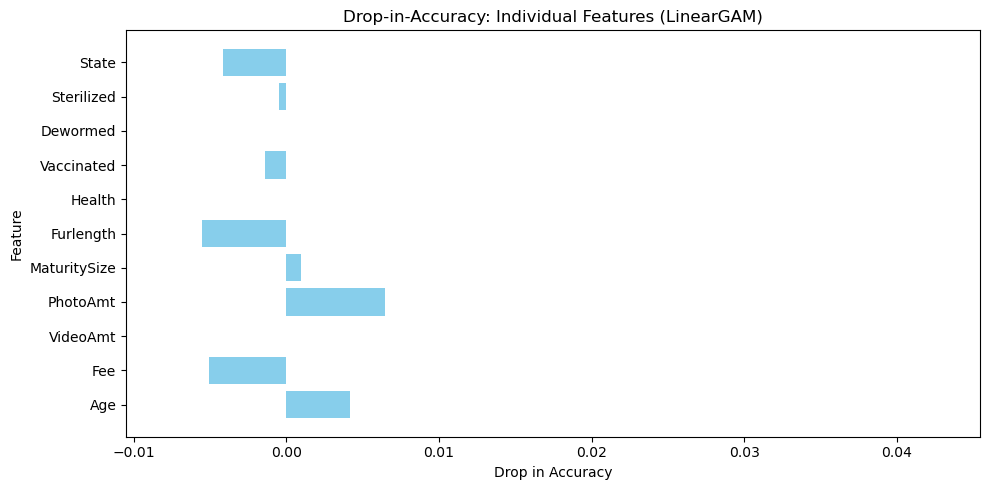

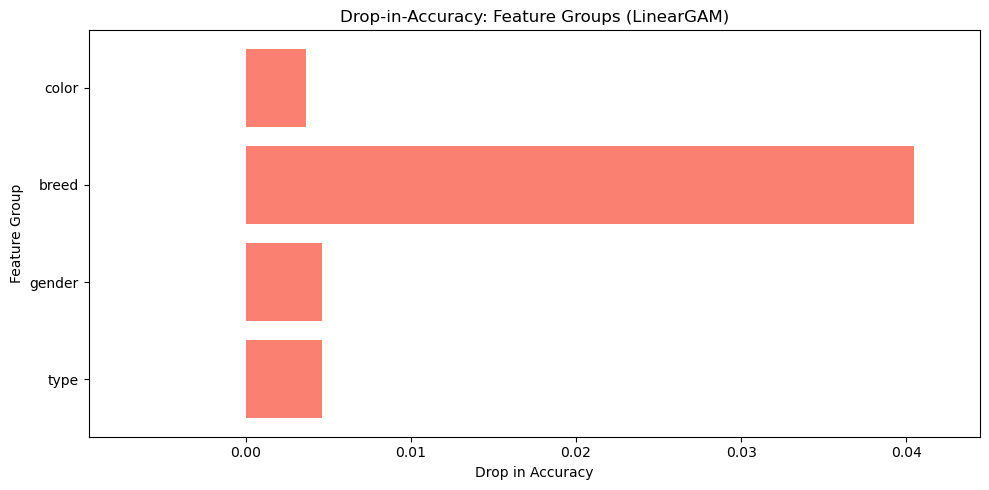

In [44]:
# Separate individual and group results
individual_results = [(f, d) for f, d in drop_in_accuracies if f.startswith("feature_")]
group_results = [(g, d) for g, d in drop_in_accuracies if g in feature_groups]

# Find range for consistent axis limits
all_drops = [d for _, d in drop_in_accuracies]
x_min, x_max = min(all_drops), max(all_drops)

# Plot individual features
if individual_results:
    features, drops = zip(*individual_results)

    # Replace internal names with readable ones if needed
    features = ['Age', 'Fee', 'VideoAmt', 'PhotoAmt',
                'MaturitySize', 'Furlength', 'Health',
                'Vaccinated', 'Dewormed', 'Sterilized', 'State']

    plt.figure(figsize=(10, 5))
    plt.barh(features, drops, color='skyblue')
    plt.xlim(x_min - 0.005, x_max + 0.005)
    plt.xlabel("Drop in Accuracy")
    plt.ylabel("Feature")
    plt.title("Drop-in-Accuracy: Individual Features (LinearGAM)")
    plt.tight_layout()
    plt.show()

# Plot grouped features
if group_results:
    groups, drops = zip(*group_results)

    plt.figure(figsize=(10, 5))
    plt.barh(groups, drops, color='salmon')
    plt.xlim(x_min - 0.004, x_max + 0.004)
    plt.xlabel("Drop in Accuracy")
    plt.ylabel("Feature Group")
    plt.title("Drop-in-Accuracy: Feature Groups (LinearGAM)")
    plt.tight_layout()
    plt.show()

In [51]:
# Define features to remove
features_to_remove = ["num__Age", "target__Breed1_encoded", "target__Breed2_encoded"]

# Get all feature names from the preprocessor
all_features = preprocessor.get_feature_names_out()

# Identify indices of features to remove
indices_to_remove = [i for i, col in enumerate(all_features) if col in features_to_remove]

# Remove the selected columns from the processed data
X_train_reduced = np.delete(X_train_processed, indices_to_remove, axis=1)
X_val_reduced = np.delete(X_val_processed, indices_to_remove, axis=1)

# Train a new LinearGAM without the removed features
gam_reduced1 = LinearGAM().fit(X_train_reduced, y_train_ordered)

# Predict and post-process
y_val_pred = gam_reduced1.predict(X_val_reduced)
y_val_pred_rounded = np.clip(np.round(y_val_pred).astype(int), 0, 4)

# Evaluate the reduced model
reduced_accuracy = accuracy_score(y_val_ordered, y_val_pred_rounded)

# Evaluate baseline LinearGAM
y_val_pred_baseline = gam.predict(X_val_processed)
y_val_pred_baseline_rounded = np.clip(np.round(y_val_pred_baseline).astype(int), 0, 4)
baseline_accuracy = accuracy_score(y_val_ordered, y_val_pred_baseline_rounded)

# Compare
accuracy_drop = baseline_accuracy - reduced_accuracy

# Print results
print(f"Baseline Accuracy (with all features): {baseline_accuracy:.4f}")
print(f"Reduced Accuracy (without Age and Breed): {reduced_accuracy:.4f}")
print(f"Drop in Accuracy: {accuracy_drop:.4f}")

Baseline Accuracy (with all features): 0.3108
Reduced Accuracy (without Age and Breed): 0.2703
Drop in Accuracy: 0.0405


## TODO 完善两种GAM的对比图


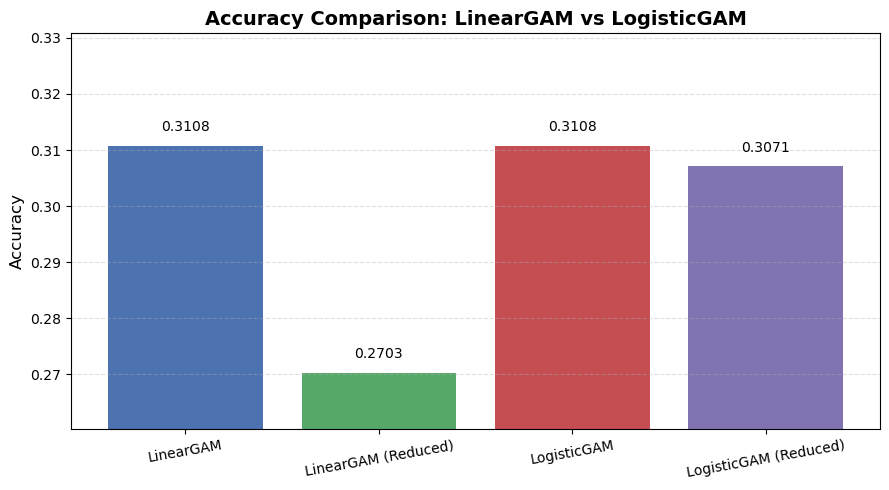

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# 模型名称与对应准确率变量
model_names = ['LinearGAM', 'LinearGAM (Reduced)', 'LogisticGAM', 'LogisticGAM (Reduced)']
accuracies = [baseline_accuracy1, reduced_accuracy1, baseline_accuracy, reduced_accuracy]

# 定义颜色：前两种是Linear，后两种是Logistic
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2']

# 设置画布大小
plt.figure(figsize=(9, 5))

# 绘制条形图
bars = plt.bar(model_names, accuracies, color=colors)

# 添加准确率标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.002, f'{height:.4f}',
             ha='center', va='bottom', fontsize=10)

# 添加轴标签和标题
plt.ylabel("Accuracy", fontsize=12)
plt.title("Accuracy Comparison: LinearGAM vs LogisticGAM", fontsize=14, weight='bold')

# 自动适应 y 轴范围并留一点顶部空间
plt.ylim(min(accuracies) - 0.01, max(accuracies) + 0.02)

# x 轴旋转
plt.xticks(rotation=10, fontsize=10)

# 添加图例说明颜色归属（可选）
handles = [
    plt.Rectangle((0, 0), 1, 1, color=colors[0], label='LinearGAM'),
    plt.Rectangle((0, 0), 1, 1, color=colors[2], label='LogisticGAM')
]

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()

# 可选：保存图像
# plt.savefig("gam_accuracy_comparison.png", dpi=300)

plt.show()